[[ 0.00000000e+00  0.00000000e+00  4.78395101e-03]
 [ 1.00000000e+00 -1.00000000e+00 -7.78269642e-08]
 [ 1.00000000e+00  0.00000000e+00  4.56294650e-19]
 [ 1.00000000e+00  1.00000000e+00  7.78269642e-08]
 [ 2.00000000e+00 -2.00000000e+00 -8.13492334e-04]
 [ 2.00000000e+00 -1.00000000e+00 -9.80211365e-06]
 [ 2.00000000e+00  0.00000000e+00  2.83835196e-04]
 [ 2.00000000e+00  1.00000000e+00  9.80211365e-06]
 [ 2.00000000e+00  2.00000000e+00 -8.13492334e-04]]


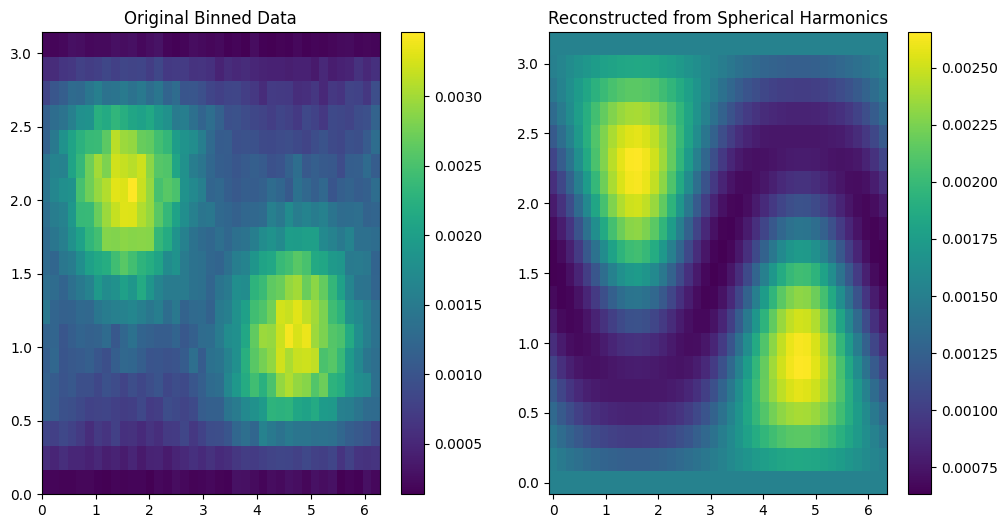

In [4]:
import numpy as np
from scipy.special import sph_harm
import matplotlib.pyplot as plt

def to_spherical(cartesian_coords):
    """
    Convert cartesian coordinates to spherical coordinates (theta, phi).
    theta: polar angle [0, pi]
    phi: azimuthal angle [0, 2pi]
    """
    x, y, z = cartesian_coords[:, 0], cartesian_coords[:, 1], cartesian_coords[:, 2]
    r = np.linalg.norm(cartesian_coords, axis=1)  # radius, should be 1 for unit vectors
    theta = np.arccos(z / r)  # polar angle
    phi = np.arctan2(y, x)  # azimuthal angle
    return theta, phi

def bin_spherical_coordinates(theta, phi, num_bins=20):
    """
    Bin the spherical coordinates (theta, phi) into a 2D histogram.
    """
    # Create a 2D histogram with num_bins for both theta and phi
    theta_bins = np.linspace(0, np.pi, num_bins)  # theta goes from 0 to pi
    phi_bins = np.linspace(-np.pi, np.pi, 2*num_bins)  # phi goes from 0 to 2pi

    hist, theta_edges, phi_edges = np.histogram2d(theta, phi, bins=[theta_bins, phi_bins])
    
    # Normalize the histogram
    hist = hist / np.sum(hist)
    return hist, theta_edges, phi_edges

def fit_spherical_harmonics(hist, theta_edges, phi_edges, max_l=5):
    """
    Fit spherical harmonics to the binned data (up to max_l order).
    """
    # Compute the bin centers
    theta_centers = (theta_edges[:-1] + theta_edges[1:]) /2
    phi_centers = (phi_edges[:-1] + phi_edges[1:]) / 2

    # Create a meshgrid of theta, phi bin centers
    theta_grid, phi_grid = np.meshgrid(theta_centers, phi_centers, indexing='ij')

    # Flatten the theta and phi grids for fitting
    theta_flat = theta_grid.flatten()
    phi_flat = phi_grid.flatten()
    hist_flat = hist.flatten()

    # Initialize arrays for the spherical harmonics expansion coefficients
    coefficients = []

    # Fit the spherical harmonics up to degree l = max_l
    for l in range(max_l + 1):
        for m in range(-l, l + 1):
            # Compute spherical harmonics values at each (theta, phi) bin center
            Y_lm = sph_harm(m, l, phi_flat, theta_flat)
            # Use least squares to fit the coefficients
            c_lm = np.dot(hist_flat, Y_lm.conjugate()) / np.sum(np.abs(Y_lm)**2)
            coefficients.append((l, m, c_lm))

    return coefficients

def reconstruct_from_spherical_harmonics(coefficients, theta, phi):
    """
    Reconstruct the function from spherical harmonics using the fitted coefficients.
    """
    f_reconstructed = np.zeros_like(theta, dtype=complex)

    for l, m, c_lm in coefficients:
        Y_lm = sph_harm(m, l, phi, theta)
        f_reconstructed += c_lm * Y_lm

    return np.real(f_reconstructed)

def generate_symmetric_biased_vectors(num_vectors, preferred_direction, bias_strength=0.1):
    """
    Generate biased random vectors with a preference towards a given direction and 
    account for symmetry by adding opposite directions.
    """
    # Normalize the preferred direction
    preferred_direction = preferred_direction / np.linalg.norm(preferred_direction)
    
    # Generate random vectors
    random_vectors = np.random.normal(size=(num_vectors, 3))
    
    # Blend random vectors with the preferred direction based on bias strength
    biased_vectors = (1 - bias_strength) * preferred_direction + bias_strength * random_vectors
    
    # Normalize the biased vectors
    normalized_vectors = biased_vectors / np.linalg.norm(biased_vectors, axis=1)[:, np.newaxis]

    # Now create symmetric vectors by adding both the original and their opposites
    symmetric_vectors = np.vstack([normalized_vectors, -normalized_vectors])

    return symmetric_vectors


# Parameters
num_vectors = 100000
preferred_direction = np.array([0, 1, 1])  # Preferred orientation (e.g., along the z-axis)

# Generate contact normals, symmetric about the origin (include opposite direction)
contact_normals = generate_symmetric_biased_vectors(num_vectors, preferred_direction, bias_strength=0.5)

# Convert contact normals from Cartesian to spherical coordinates
theta, phi = to_spherical(contact_normals)

# Bin the contact normals on the unit sphere
hist, theta_edges, phi_edges = bin_spherical_coordinates(theta, phi, num_bins=20)

# Correct phi range for visualization
phi_edges += np.pi

# Fit spherical harmonics to the binned contact normal distribution (up to second order)
coefficients = fit_spherical_harmonics(hist, theta_edges, phi_edges, max_l=2)
print(np.real(coefficients))
# Reconstruct the distribution from spherical harmonics
theta_reconstructed, phi_reconstructed = np.meshgrid(theta_edges, phi_edges, indexing='ij')
reconstructed_hist = reconstruct_from_spherical_harmonics(coefficients, theta_reconstructed, phi_reconstructed)

# Plot the original binned data vs. the reconstructed approximation
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original binned data
c1 = ax[0].pcolormesh(phi_edges, theta_edges, hist, shading='auto', cmap='viridis')
ax[0].set_title('Original Binned Data')
fig.colorbar(c1, ax=ax[0])

# Reconstructed from spherical harmonics
c2 = ax[1].pcolormesh(phi_edges, theta_edges, reconstructed_hist, shading='auto', cmap='viridis')
ax[1].set_title('Reconstructed from Spherical Harmonics')
fig.colorbar(c2, ax=ax[1])

plt.show()


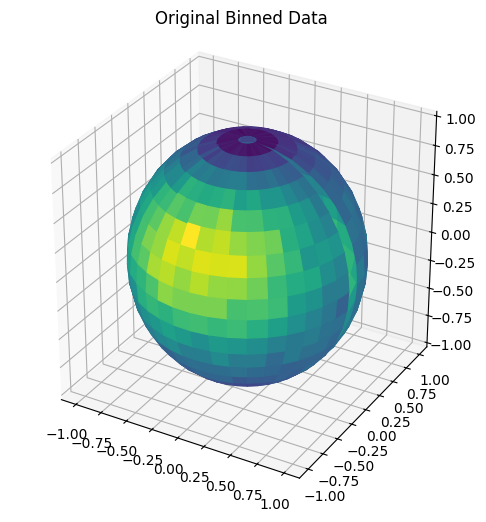

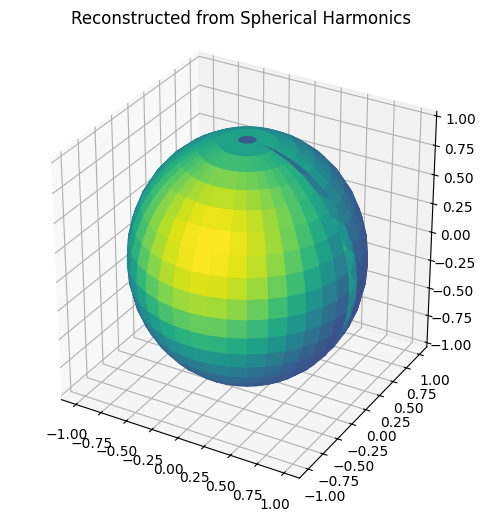

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the function to convert spherical to Cartesian coordinates
def spherical_to_cartesian(theta, phi, r=1):
    """
    Convert spherical coordinates to Cartesian coordinates.
    theta: Polar angle [0, pi]
    phi: Azimuthal angle [-pi, pi]
    r: Radius (default 1 for unit sphere)
    Returns x, y, z coordinates.
    """
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

# Plot the data on the surface of a sphere
def plot_on_sphere(theta_edges, phi_edges, data, title):
    """
    Plot the data on a sphere.
    """
    theta_centers = (theta_edges[:-1] + theta_edges[1:]) / 2
    phi_centers = (phi_edges[:-1] + phi_edges[1:]) / 2

    # Create a meshgrid of theta and phi
    theta_grid, phi_grid = np.meshgrid(theta_centers, phi_centers, indexing='ij')

    # Convert the theta and phi to Cartesian coordinates
    x, y, z = spherical_to_cartesian(theta_grid, phi_grid)

    # Plot the data on the sphere
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z, facecolors=plt.cm.viridis(data / np.max(data)), rstride=1, cstride=1, antialiased=True, shade=False)
    ax.set_title(title)
    ax.set_box_aspect([1,1,1])  # Equal aspect ratio

    plt.show()

# Now use the function to plot the original binned data and reconstructed data on a sphere
plot_on_sphere(theta_edges, phi_edges, hist, "Original Binned Data")
plot_on_sphere(theta_edges, phi_edges, reconstructed_hist, "Reconstructed from Spherical Harmonics")

In [21]:
a = np.random.randn(10,3)
b = np.random.rand(10,3)
print(a)
print(b)

[[-0.11650227  0.1329193  -0.84892921]
 [ 0.08551367 -0.36595227  0.34147788]
 [ 1.31540413  0.82636036  0.40725709]
 [ 0.45550397 -1.89404806  0.73006817]
 [-0.10348167  0.62332344 -0.20769474]
 [ 0.01557094 -1.39481986  0.44142944]
 [-0.80725296  0.71192058  0.58335017]
 [-0.54552123 -0.58471749 -1.35481381]
 [-0.0675108  -0.50299917  1.78300881]
 [-0.95119324 -1.69974764 -0.40504602]]
[[0.10444346 0.00896939 0.80268102]
 [0.60082304 0.24282946 0.49988995]
 [0.1798345  0.85709356 0.83183699]
 [0.15269976 0.30485559 0.70914645]
 [0.30651576 0.52663946 0.35531567]
 [0.66338999 0.26689611 0.29616139]
 [0.75220854 0.83593108 0.86581441]
 [0.11577436 0.61457228 0.90956575]
 [0.12396847 0.93143589 0.53933552]
 [0.61186975 0.34269931 0.05468099]]


In [14]:
np.dot(a,b.T).shape

(10, 10)

In [28]:
np.einsum('ij, ij->i', a, b)

array([-0.69239507,  0.13321595,  1.28359471,  0.00986945,  0.22275076,
       -0.23120803,  0.49296696, -1.65480076,  0.48475929, -1.18665702])

In [23]:
a[0,0]*b[0,0]+a[0,1]*b[0,1]+a[0,2]*b[0,2]

np.float64(-0.6923950674159954)

In [25]:
np.linalg.norm(a*b, axis=1)

array([0.68152904, 0.19918716, 0.81998061, 0.77864049, 0.33795139,
       0.39469559, 0.98892956, 1.28517169, 1.06973104, 0.82372989])

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import rcParams
from matplotlib.cm import viridis, plasma, cividis, inferno
from matplotlib import cm
from matplotlib import cm, colors as mcolors
def plot_histogram_ellipsoid(hist_local, bins_local, title, label, is_prolate=True, colormap='YlGnBu'):
        """
        Plot an ellipsoid with axis-symmetric stripes based on the histogram of angles.

        Args:
        - hist_local (array): The histogram values to map onto the ellipsoid.
        - bins_local (array): The bin edges for the angles.
        - title (str): Title for the plot.
        - label (str): Label for the color bar.
        - is_prolate (bool): If True, plot a prolate ellipsoid; else plot an oblate ellipsoid.
        - colormap (str): The colormap to use for the plot.
        """
        ap = 3
        is_prolate = True  # Fixed to plot a prolate ellipsoid in this example

        # Create a grid of u (azimuthal angle) and v (polar angle)
        u = np.linspace(0, 2 * np.pi, 50)  # azimuthal angle
        v = np.linspace(0, np.pi, len(bins_local))  # use bins_local length for polar angle divisions

        # Parametric equations for the ellipsoid
        if is_prolate:
            x = np.outer(np.sin(v), np.cos(u))
            y = np.outer(np.sin(v), np.sin(u))
            z = ap * np.outer(np.cos(v), np.ones_like(u))
        else:  # Oblate ellipsoid
            x = ap * np.outer(np.cos(v), np.ones_like(u))
            y = np.outer(np.sin(v), np.cos(u))
            z = np.outer(np.sin(v), np.sin(u))

        # Calculate the bin centers to map the colors
        bin_centers = (bins_local[:-1] + bins_local[1:]) / 2
        print(z.shape)
        print(bin_centers.shape)
        # Create a color array where each stripe corresponds to a histogram bin
        colors = np.zeros_like(z)

        # Define a normalization object using the original range of `hist_local`
        norm = mcolors.Normalize(vmin=np.min(hist_local), vmax=np.max(hist_local))
        # Map the histogram values to the stripes on the ellipsoid surface
        for i in range(len(bin_centers)):
            # # Upper hemisphere (v from 0 to 90 degrees)
            indices_upper = (v >= np.radians(bins_local[i])) & (v < np.radians(bins_local[i + 1]))
            smoothed_color = hist_local[i]
            colors[indices_upper, :] = smoothed_color 

            # Mirror to the lower hemisphere (v from 90 to 180 degrees)
            indices_lower = (v >= np.radians(180 - bins_local[i + 1])) & (v < np.radians(180 - bins_local[i]))
            colors[indices_lower, :] = smoothed_color

        # Plotting the ellipsoid with the histogram-based colormap
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Use a colormap to plot the surface, passing in the normalized color array
        cmap = cm.get_cmap(colormap)
        ax.plot_surface(x, y, z, facecolors=cmap(norm(colors)), rstride=1, cstride=1, antialiased=True, alpha=1.0)

        # Add some labels and set the aspect ratio
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_aspect('equal')
        ax.axis('off')
        
        # Adjust the view based on ellipsoid type
        if is_prolate:
            ax.view_init(elev=-26, azim=-6, roll=30)
        else:
            ax.view_init(elev=-55, azim=-56)

        # Add a colorbar with the same normalization
        mappable = cm.ScalarMappable(cmap=cmap, norm=norm)
        mappable.set_array(hist_local)  # Attach data for color bar
        cbar = plt.colorbar(mappable, ax=ax, shrink=0.5, aspect=5)
        cbar.ax.tick_params(labelsize=20)
        cbar.set_label(label=label, fontsize=20)

        plt.show()


Bin centers: [ 4.5 13.5 22.5 31.5 40.5 49.5 58.5 67.5 76.5 85.5], Length: 10


/tmp/ipykernel_35935/374857531.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap)


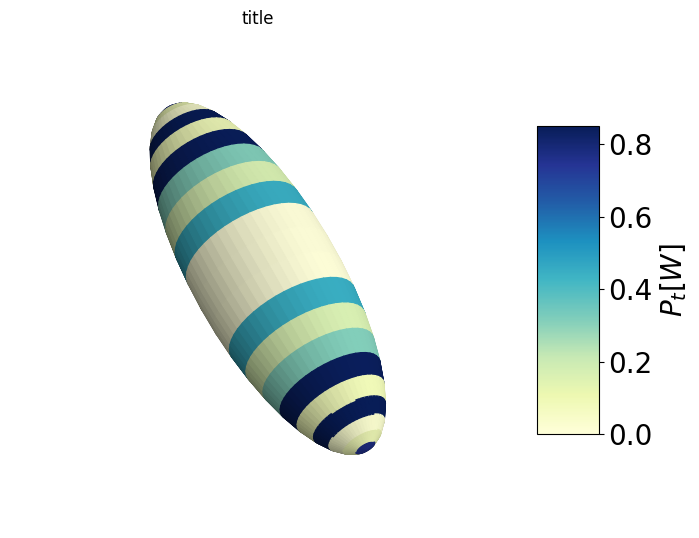

[0.75790871 0.09006039 0.02959082 0.85004681 0.08685841 0.84218909
 0.31538674 0.16485483 0.44706851 0.        ]


In [21]:
def plot_histogram_ellipsoid(hist_local, bins_local, title, label, is_prolate=True, colormap='YlGnBu'):
    """
    Plot an ellipsoid with axis-symmetric stripes based on the histogram of angles.

    Args:
    - hist_local (array): The histogram values to map onto the ellipsoid.
    - bins_local (array): The bin edges for the angles.
    - title (str): Title for the plot.
    - label (str): Label for the color bar.
    - is_prolate (bool): If True, plot a prolate ellipsoid; else plot an oblate ellipsoid.
    - colormap (str): The colormap to use for the plot.
    """
    ap = 3

    # Create a grid of u (azimuthal angle) and v (polar angle)
    u = np.linspace(0, 2 * np.pi, 50)  # Fine azimuthal resolution for smoothness
    v = np.linspace(0, np.pi, 2*len(bins_local) + 1)  # Match polar resolution to histogram bins

    # Parametric equations for the ellipsoid
    if is_prolate:
        x = np.outer(np.sin(v), np.cos(u))
        y = np.outer(np.sin(v), np.sin(u))
        z = ap * np.outer(np.cos(v), np.ones_like(u))
    else:  # Oblate ellipsoid
        x = ap * np.outer(np.cos(v), np.ones_like(u))
        y = np.outer(np.sin(v), np.cos(u))
        z = np.outer(np.sin(v), np.sin(u))

    # Calculate the bin centers to map the colors
    bin_centers = (bins_local[:-1] + bins_local[1:]) / 2
    print(f"Bin centers: {bin_centers}, Length: {len(bin_centers)}")
    
    # Initialize the color array for the ellipsoid surface
    colors = np.zeros_like(z)

    # Define a normalization object using the original range of `hist_local`
    norm = mcolors.Normalize(vmin=np.min(hist_local), vmax=np.max(hist_local))

    # Map histogram values to both hemispheres of the ellipsoid
    for i in range(len(bin_centers)):
        # Upper hemisphere (v from 0 to 90 degrees)
        indices_upper = (v >= np.radians(bins_local[i])) & (v < np.radians(bins_local[i + 1]))
        colors[indices_upper, :] = hist_local[i]

        # Symmetrically map the same value to the lower hemisphere (90 to 180 degrees)
        indices_lower = (v >= np.radians(180 - bins_local[i + 1])) & (v < np.radians(180 - bins_local[i]))
        colors[indices_lower, :] = hist_local[i]

    # Plotting the ellipsoid with the histogram-based colormap
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Use a colormap to plot the surface, passing in the normalized color array
    cmap = cm.get_cmap(colormap)
    ax.plot_surface(x, y, z, facecolors=cmap(norm(colors)), rstride=1, cstride=1, antialiased=True, alpha=1.0)

    # Add some labels and set the aspect ratio
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Adjust the view based on ellipsoid type
    if is_prolate:
        ax.view_init(elev=-26, azim=-6, roll=30)
    else:
        ax.view_init(elev=-55, azim=-56)

    # Add a colorbar with the same normalization
    mappable = cm.ScalarMappable(cmap=cmap, norm=norm)
    mappable.set_array(hist_local)  # Attach data for color bar
    cbar = plt.colorbar(mappable, ax=ax, shrink=0.5, aspect=5)
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(label=label, fontsize=20)

    plt.title(title)
    plt.show()
    
shape = 10
array = np.random.rand(shape)
array[-1] = 0
bins_local = np.linspace(0, 90, shape+1)
plot_histogram_ellipsoid(array, bins_local, "title",'$P_t [W]$', is_prolate = True)
print(array)

In [12]:
print(array.shape)
print(bins_local.shape)

(10,)
(11,)
